In [96]:
import numpy as np
import ray
import matplotlib.pyplot as plt

from mdps.cartpole import ContextualCartpole
from utils.distributions import ConstantDistribution, ParticleDistribution

# Contextual Cartpole

This notebook studies using particle filtering to estimate the context parameters of a standard cartpole environment.

# Set target

We first create a target config, $c$. This will be the $MDP(c)$ the expert uses to generate the observational data.

In [3]:
# true (expert) context: [gravity, masscart, masspole, length, noise, confound] =
#                        [9.8, 1., 0.1, 0.5, 0.15, 1.]
c = {'context_distribution':
         ConstantDistribution(dim=6,
                              constant_vector=np.array([9.8, 1., 0.1, 0.5, 0.15, 1.]))}

Train an expert that masters this context.

In [5]:
from ray.rllib.agents import ppo

ray.shutdown()
ray.init()
expert = ppo.PPOTrainer(env=ContextualCartpole, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(30):
    res = expert.train()
    print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-02-07 13:35:22,166	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-02-07 13:35:24,545	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 22.59090909090909
1 40.79
2 61.47
3 84.7
4 106.66
5 124.5
6 137.93
7 148.95
8 164.02
9 176.25
10 186.77
11 197.93
12 206.95
13 209.92
14 211.31
15 226.58
16 229.43
17 233.17
18 244.61
19 253.61
20 258.1
21 269.49
22 273.21
23 282.17
24 292.59
25 300.15
26 299.24
27 302.21
28 316.41
29 322.31


In [55]:
# collect expert rollout
env = ContextualCartpole(config=c)
done = False
obs = env.reset()
# run until episode ends
gt_obs_arr = None
while not done:
    action = expert.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    if gt_obs_arr is None:
        gt_obs_arr = obs
    else:
        gt_obs_arr = np.vstack((gt_obs_arr, obs))

In [56]:
gt_obs_arr.shape

(263, 4)

## Exact context

We first train a RL solver only on the correct context for particle filtering. We have already done this so we can directly use the expert solver.

In [199]:
# PF that resamples only after all episodes are done
N = 10000
T = 1
R = 50
gravity = np.random.normal(loc=7.5, scale=1.5, size=(N,))
masscart = np.ones((N,)) * 0.5
masspole = np.ones((N,)) * 0.1
length = np.ones((N,))
noise = np.ones((N,)) * 0.05
confound = np.random.normal(loc=1, scale=1, size=(N,))

context_particles = np.vstack((gravity, masscart, masspole, length, noise, confound)).T
context_particles = np.abs(context_particles )
context_distribution = ParticleDistribution(dim=6, particles=context_particles, n_particles=N)

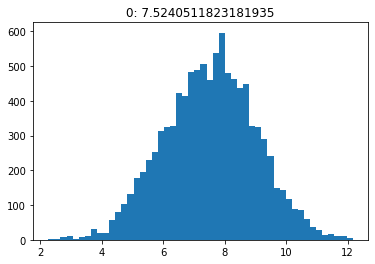

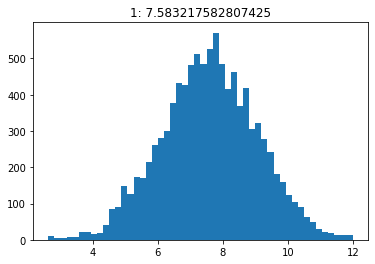

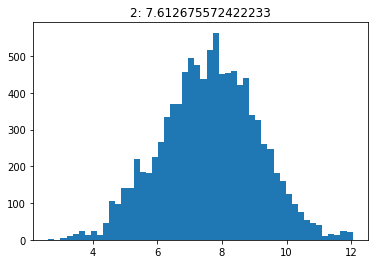

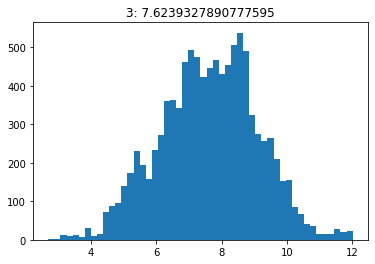

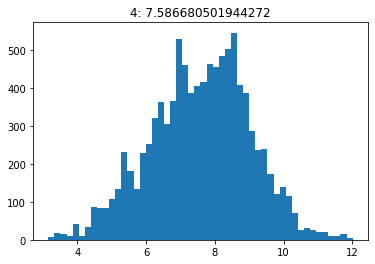

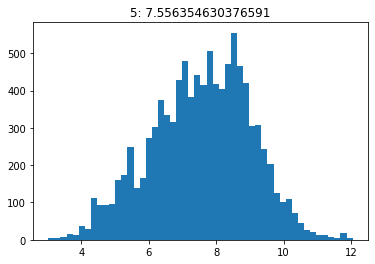

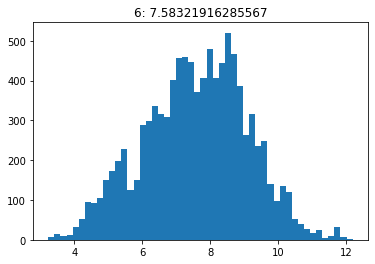

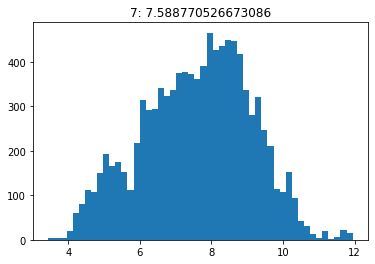

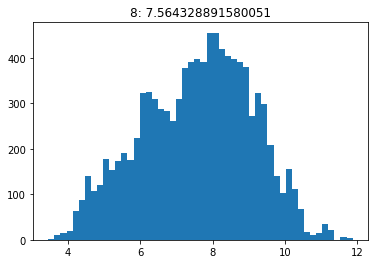

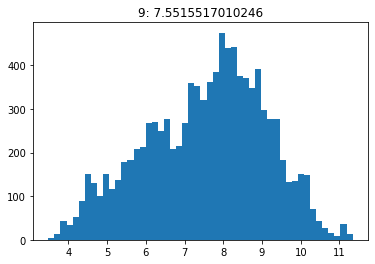

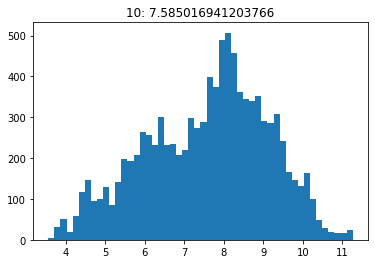

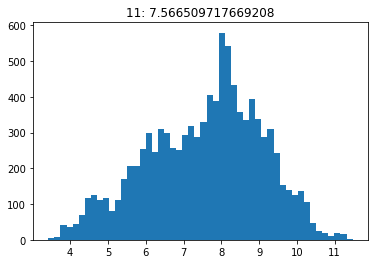

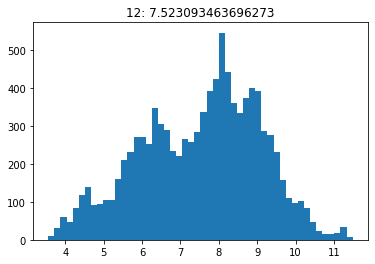

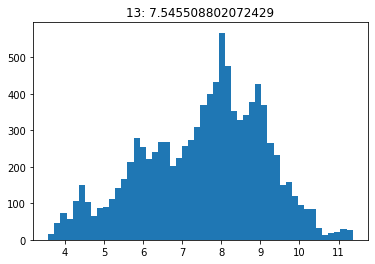

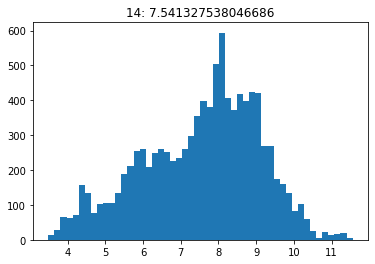

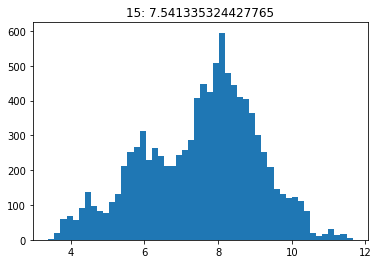

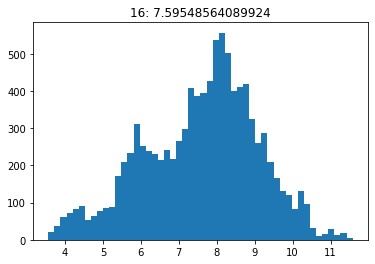

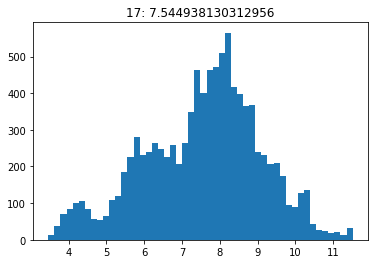

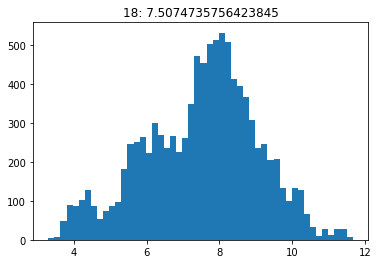

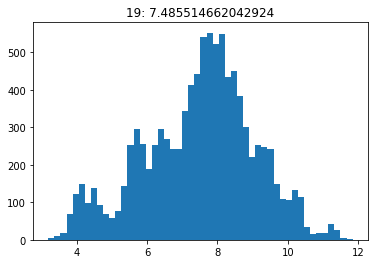

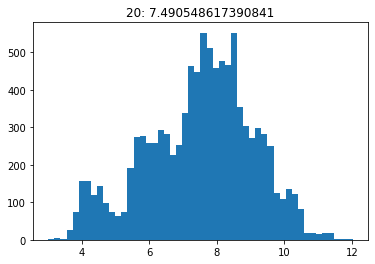

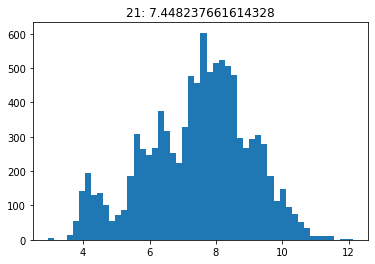

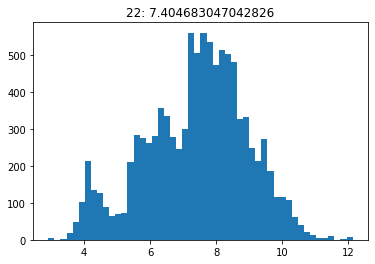

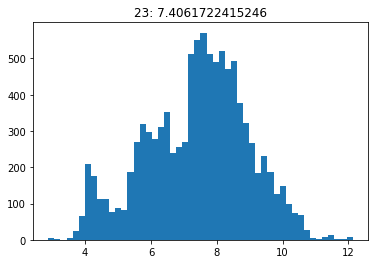

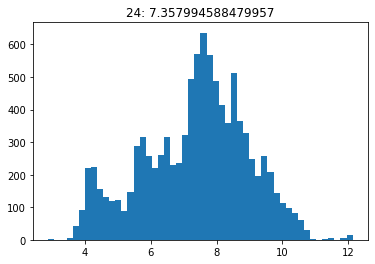

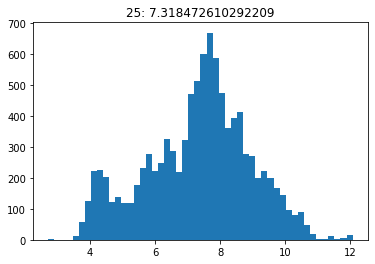

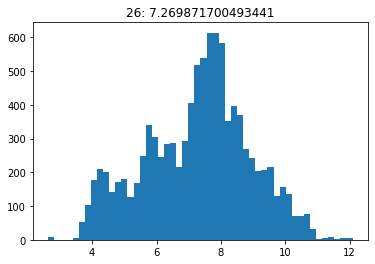

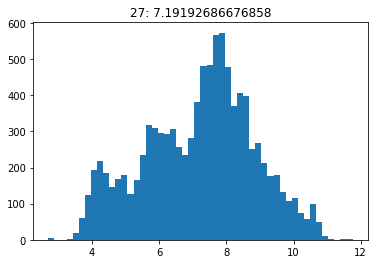

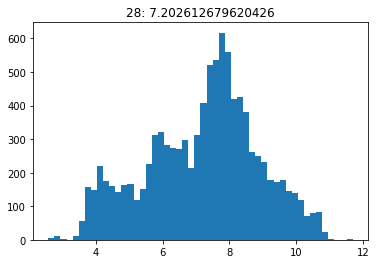

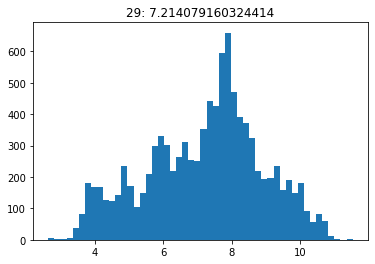

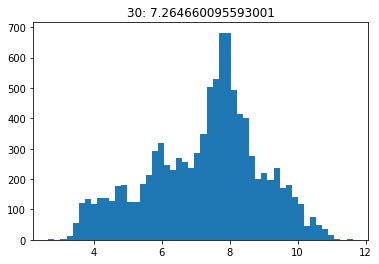

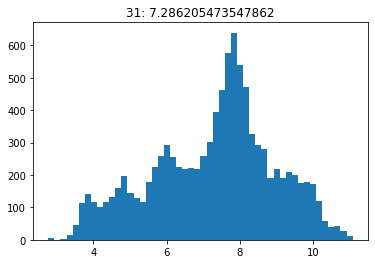

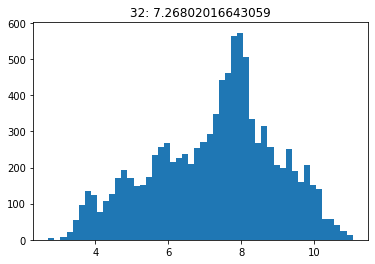

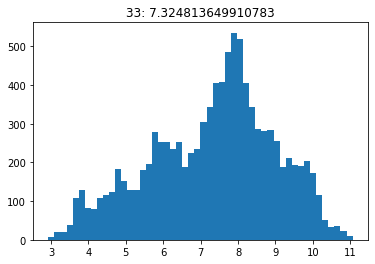

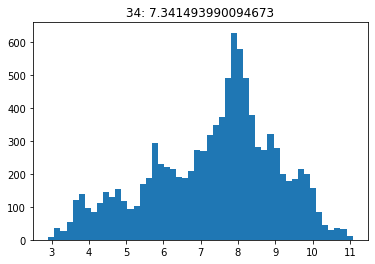

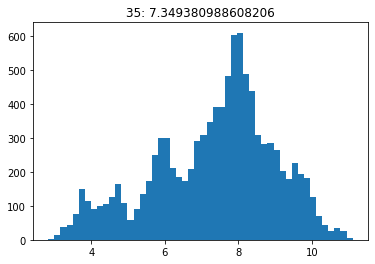

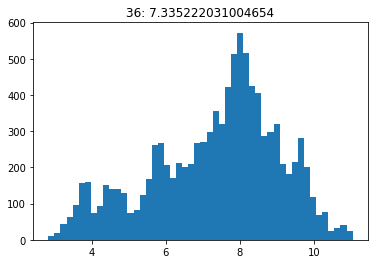

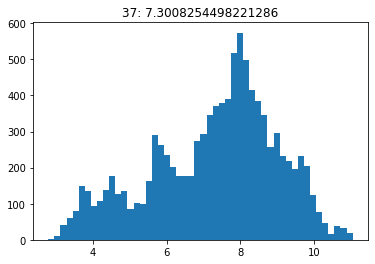

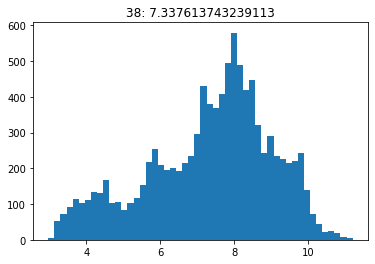

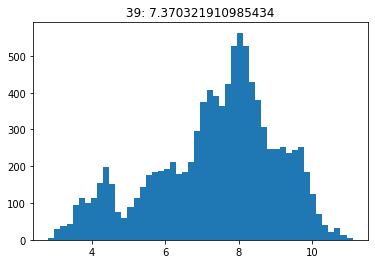

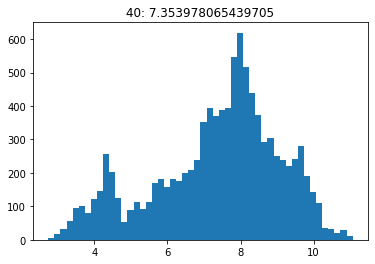

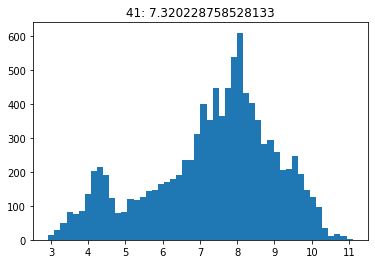

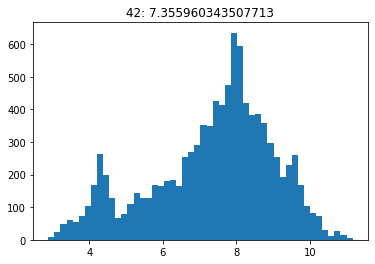

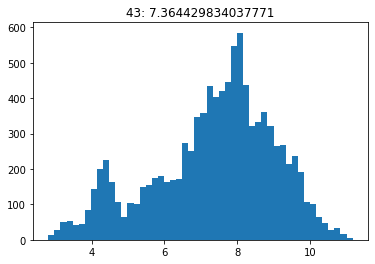

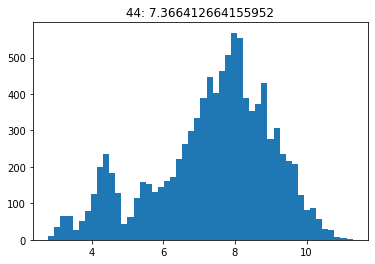

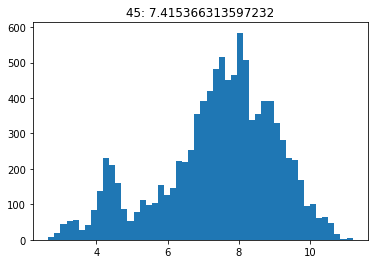

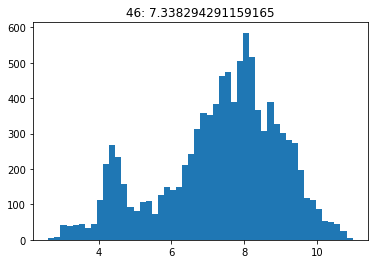

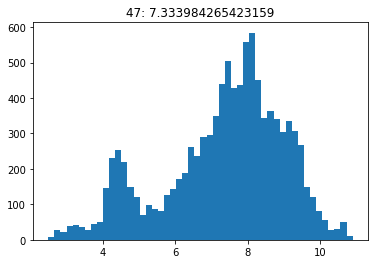

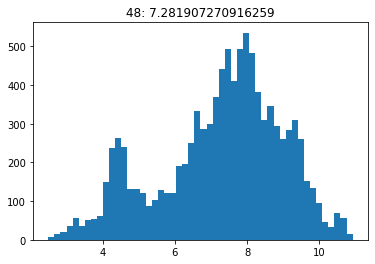

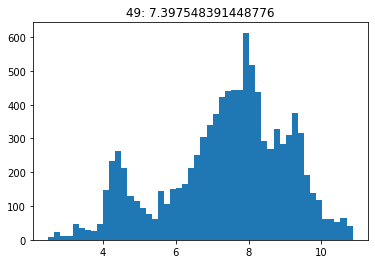

In [200]:
obs_arr = None
solver = expert
for r in range(R):
    # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
    qs = np.zeros((N,))
    for n in range(N):
        context = context_distribution.particles[n,:]
        c_local = {'context_distribution':
                   ConstantDistribution(dim=6,
                                        constant_vector=context)}
        env = ContextualCartpole(config=c_local)
        done = False
        obs = env.reset()
        if r > 0:
            env.state = obs_arr[-1]
        t = 0
        # run until episode ends
        while (not done) and t<T:
            action = solver.compute_single_action(obs)
            obs, reward, done, info = env.step(action)
            error = (gt_obs_arr[t] - obs).mean()
            qs[n] += -0.5*(error / context[4])**2
            t += 1
        if obs_arr is None:
            obs_arr = np.array(obs).flatten()
        else:
            obs_arr = np.vstack((obs_arr, np.array(obs).flatten()))
    qs = np.exp(qs)
    qs = qs/qs.sum()
    resample_index = context_distribution.resample_particles_from_probability(p=qs)
    ptemp = context_distribution.particles
    n = np.random.normal(loc=0, scale=ptemp.std(axis=0), size=ptemp.shape) * 0.05
    context_distribution.particles += n
    obs_arr = obs_arr[resample_index]
    plt.hist(context_distribution.particles[:,0], bins=50)
    plt.title(f"{r}: {context_distribution.particles[:,0].mean()}")
    plt.show()

# Mis-specified context

We also see what happens if we train a solver only on an MDP $MDP(c_{miss})$, where $c_{miss}$ is a mis-specified context.

In [35]:
# We try a short cartpole on a planet with g=5.0. We also slightly reduce noise to 0.1.
c_mis = {'context_distribution':
             ConstantDistribution(dim=5,
                                  constant_vector=np.array([5, 0.5, 0.1, 0.5, 0.1, 1.]))}

ray.shutdown()
ray.init()
mis_solver = ppo.PPOTrainer(env=ContextualCartpole, config={
    "env_config": c_mis,
    "framework": "torch",  # config to pass to env class
})

for eps in range(30):
    res = mis_solver.train()
    print(eps, res['episode_reward_mean'])

2022-02-07 13:48:02,099	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-02-07 13:48:04,570	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 16.520661157024794
1 29.116788321167885
2 46.22
3 68.62
4 90.35
5 115.09
6 130.48
7 151.13
8 172.98
9 187.48
10 204.04
11 216.97
12 243.83
13 262.72
14 293.09
15 312.45
16 350.85
17 376.13
18 390.21
19 418.78
20 473.69
21 486.92
22 525.33
23 525.33
24 551.49
25 649.67
26 688.52
27 688.52
28 718.98
29 718.98
